## Logistic VCM Results 

This notebook goes over the code needed to reproduce the results from the MSE and time figures for the Bernoulli base distribution with Logit Link and covariance matrix $\Gamma$ structured under variance component model framework as follows:

$$
\Gamma = \sigma_1 * \mathbf{1_{n} 1_{n}^\top}
$$

We run each scenario 5 times and compare the fit with that of GLMM's random intercept model from MixedModels.jl. 

In [1]:
versioninfo()

Julia Version 1.5.2
Commit 539f3ce943 (2020-09-23 23:17 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin18.7.0)
  CPU: Intel(R) Core(TM) i9-9880H CPU @ 2.30GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-9.0.1 (ORCJIT, skylake)


In [2]:
using GLMCopula, DelimitedFiles, LinearAlgebra, Random, GLM
using Random, Roots, SpecialFunctions, DataFrames

In [3]:
p  = 3    # number of fixed effects, including intercept
m  = 1    # number of variance components
# true parameter values
βtrue = ones(p)
Σtrue = [0.1]

# generate data
intervals = zeros(p + m, 2) #hold intervals
curcoverage = zeros(p + m) #hold current coverage resutls
trueparams = [βtrue; Σtrue] #hold true parameters

#simulation parameters
samplesizes = [1000; 10000; 50000]
ns = [5; 10; 20; 50]
nsims = 5

5

In [4]:
ENV["COLUMNS"] = 1000
@info "reading in the files with results"
βMseresult = vec(readdlm("mse_beta_logistic_multivariate_vcm$(nsims)reps_sim.csv", ','))
ΣMseresult = vec(readdlm("mse_Sigma_logistic_multivariate_vcm$(nsims)reps_sim.csv", ','))
fittimes_QC = vec(readdlm("fittimes_logistic_multivariate_vcm$(nsims)reps_sim.csv", ','))

┌ Info: reading in the files with results
└ @ Main In[4]:2


60-element Array{Float64,1}:
   1.593511842
   0.203021267
   0.229318302
   0.183770943
   0.14911712
   0.183658722
   0.149674359
   0.169916435
   0.180250482
   0.250256974
   0.244536744
   0.223201378
   0.254817702
   ⋮
  12.479306276
  45.948507754
  10.232191611
  62.661861737
  65.651079418
 112.547135158
  10.96673463
  51.541712363
 150.971945263
  22.848728962
  22.948348749
  78.591001815

In [5]:
fittimes_GLMM = vec(readdlm("fittimes_logistic_GLMM_multivariate_vcm$(nsims)reps_sim.csv", ','))

60-element Array{Float64,1}:
 41.84725456
  0.160012244
  0.133138455
  0.128610125
  0.129489739
  0.243503758
  0.233819013
  0.266088577
  0.221490788
  0.261604143
  0.413698505
  0.415889307
  0.396712358
  ⋮
 46.766209382
 47.102447419
 63.699044288
 66.648484419
 66.003342374
 59.947925802
 59.140175455
 89.263703798
 95.562487614
 91.33660599
 87.544890638
 92.719352504

In [6]:
#simulation parameters
@info "making results table Quasi-Copula"
sample_sizes = repeat(string.(samplesizes), inner = nsims * length(ns))
obs_sizes = repeat(string.(ns), inner = nsims, outer = length(samplesizes))

msedf = DataFrame(βmse = βMseresult, Σmse = ΣMseresult, 
    samplesize = sample_sizes, obssize = obs_sizes, fittimes = fittimes_QC)
timedf1 = combine(groupby(msedf, [:samplesize, :obssize]), :fittimes => mean => :fittime,
    :fittimes => x -> (std(x)/sqrt(length(x))))
rename!(timedf1, Dict(:fittimes_function => "se"))
timedf1[!, :nobs] = Meta.parse.(timedf1[!, :samplesize]) .* Meta.parse.(timedf1[!, :obssize])
timedf1[!, :fitmin] = timedf1[!, :fittime] - timedf1[!, :se]
timedf1[!, :fitmax] = timedf1[!, :fittime] + timedf1[!, :se]
timedf1[!, :perobsratio] = timedf1[!, :fittime] ./ timedf1[!, :nobs]
timedf1

┌ Info: making results table Quasi-Copula
└ @ Main In[6]:2


,samplesize,obssize,fittime,se,nobs,fitmin,fitmax,perobsratio
,String,String,Float64,Float64,Int64,Float64,Float64,Float64
1,1000,5,0.471748,0.280746,5000,0.191002,0.752493,9.43496e-5
2,1000,10,0.186751,0.0169454,10000,0.169806,0.203697,1.86751e-5
3,1000,20,0.257001,0.0143238,20000,0.242678,0.271325,1.28501e-5
4,1000,50,0.599609,0.0880975,50000,0.511511,0.687706,1.19922e-5
5,10000,5,38.5394,20.8326,50000,17.7068,59.372,0.000770789
6,10000,10,2.89736,0.925312,100000,1.97205,3.82268,2.89736e-5
7,10000,20,3.68025,0.597677,200000,3.08257,4.27792,1.84012e-5
8,10000,50,6.88806,2.03226,500000,4.8558,8.92031,1.37761e-5
9,50000,5,97.3193,78.7112,250000,18.6081,176.03,0.000389277


In [7]:
#simulation parameters
@info "making results table GLMM"
sample_sizes = repeat(string.(samplesizes), inner = nsims * length(ns))
obs_sizes = repeat(string.(ns), inner = nsims, outer = length(samplesizes))

msedf = DataFrame(βmse = βMseresult, Σmse = ΣMseresult, 
    samplesize = sample_sizes, obssize = obs_sizes, fittimes = fittimes_GLMM)
timedf2 = combine(groupby(msedf, [:samplesize, :obssize]), :fittimes => mean => :fittime,
    :fittimes => x -> (std(x)/sqrt(length(x))))
rename!(timedf2, Dict(:fittimes_function => "se"))
timedf2[!, :nobs] = Meta.parse.(timedf2[!, :samplesize]) .* Meta.parse.(timedf2[!, :obssize])
timedf2[!, :fitmin] = timedf2[!, :fittime] - timedf2[!, :se]
timedf2[!, :fitmax] = timedf2[!, :fittime] + timedf2[!, :se]
timedf2[!, :perobsratio] = timedf2[!, :fittime] ./ timedf2[!, :nobs]
timedf2

┌ Info: making results table GLMM
└ @ Main In[7]:2


,samplesize,obssize,fittime,se,nobs,fitmin,fitmax,perobsratio
,String,String,Float64,Float64,Int64,Float64,Float64,Float64
1,1000,5,8.4797,8.34189,5000,0.137811,16.8216,0.00169594
2,1000,10,0.245301,0.00836633,10000,0.236935,0.253668,2.45301e-5
3,1000,20,0.422165,0.00894727,20000,0.413218,0.431113,2.11083e-5
4,1000,50,0.900601,0.0453667,50000,0.855234,0.945967,1.8012e-5
5,10000,5,2.40058,0.20195,50000,2.19863,2.60253,4.80117e-5
6,10000,10,2.76658,0.0889344,100000,2.67764,2.85551,2.76658e-5
7,10000,20,4.70237,0.162405,200000,4.53997,4.86478,2.35119e-5
8,10000,50,10.6057,0.342705,500000,10.263,10.9484,2.12113e-5
9,50000,5,41.5098,1.03085,250000,40.4789,42.5406,0.000166039


┌ Warning: RCall.jl: Warning: package ‘ggplot2’ was built under R version 4.0.2
└ @ RCall /Users/sarahji/.julia/packages/RCall/iMDW2/src/io.jl:160
┌ Warning: RCall.jl: Warning: package ‘cowplot’ was built under R version 4.0.2
└ @ RCall /Users/sarahji/.julia/packages/RCall/iMDW2/src/io.jl:160


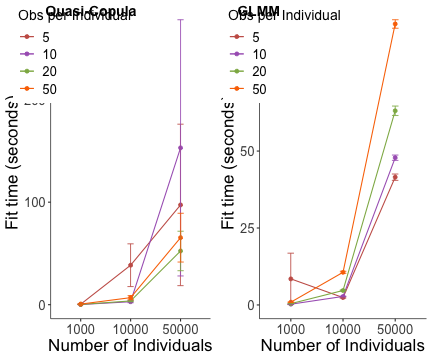

RObject{VecSxp}


In [8]:
########### plot the runtimes
using RCall
@rput timedf1
@rput timedf2
R"""
library(ggplot2)
library(cowplot)
timedf1$obssize = factor(timedf1$obssize, levels = c('5', '10', '20', '50'))
timedf1$samplesize = factor(timedf1$samplesize, levels = c('1000', '10000', '50000'))

fittime_1 = ggplot(timedf1, aes(x = samplesize, y = fittime, group = obssize, color = obssize)) + 
  geom_line() +
  geom_point()+
  geom_errorbar(aes(ymin=fitmin, ymax=fitmax), width=0.5, alpha = 0.8, position=position_dodge(0.005)) + 
  theme(legend.position=c(0.15,0.85), legend.key = element_blank(), axis.text.x = element_text(angle=0, size=13),
        axis.text.y = element_text(angle=0, size=13), axis.title.x = element_text(size = 17), 
        axis.title.y = element_text(size = 17), legend.title = element_text(size = 14),
        #axis.ticks = element_blank(),
        panel.grid.major = element_blank(), legend.text=element_text(size=13),
        panel.border = element_blank(), panel.grid.minor = element_blank(), panel.background = element_blank(), 
        axis.line = element_line(color = 'black',size=0.3), plot.title = element_text(hjust = 0.5)) + 
   scale_color_manual(values = c("#c85f55",
"#a964bf",
"#8db352",
"#fa7300",
"#05aec0")) +
  labs(x = "Number of Individuals", y = "Fit time (seconds)", color = "Obs per Individual")

timedf2$obssize = factor(timedf2$obssize, levels = c('5', '10', '20', '50'))
timedf2$samplesize = factor(timedf2$samplesize, levels = c('1000', '10000', '50000'))

fittime_2 = ggplot(timedf2, aes(x = samplesize, y = fittime, group = obssize, color = obssize)) + 
  geom_line() +
  geom_point()+
  geom_errorbar(aes(ymin=fitmin, ymax=fitmax), width=0.5, alpha = 0.8, position=position_dodge(0.005)) + 
  theme(legend.position=c(0.15,0.85), legend.key = element_blank(), axis.text.x = element_text(angle=0, size=13),
        axis.text.y = element_text(angle=0, size=13), axis.title.x = element_text(size = 17), 
        axis.title.y = element_text(size = 17), legend.title = element_text(size = 14),
        #axis.ticks = element_blank(),
        panel.grid.major = element_blank(), legend.text=element_text(size=13),
        panel.border = element_blank(), panel.grid.minor = element_blank(), panel.background = element_blank(), 
        axis.line = element_line(color = 'black',size=0.3), plot.title = element_text(hjust = 0.5)) + 
   scale_color_manual(values = c("#c85f55",
"#a964bf",
"#8db352",
"#fa7300",
"#05aec0")) +
  labs(x = "Number of Individuals", y = "Fit time (seconds)", color = "Obs per Individual")

plot_grid(fittime_1, fittime_2, labels = c("Quasi-Copula", "GLMM"))
"""

┌ Warning: RCall.jl: Warning: package ‘scales’ was built under R version 4.0.2
└ @ RCall /Users/sarahji/.julia/packages/RCall/iMDW2/src/io.jl:160


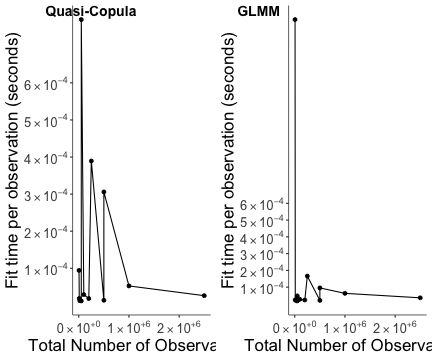

RObject{VecSxp}


In [9]:
using RCall
@rput timedf1
@rput timedf2

R"""
library(scales)
library(ggplot2)
timedf1$obssize <- factor(timedf1$obssize, levels = c('5', '10', '20'))
timedf1$samplesize <- factor(timedf1$samplesize, levels = c('1000', '10000', '50000'))

fancy_scientific <- function(l) {
     # turn in to character string in scientific notation
     l <- format(l, scientific = TRUE)
     # quote the part before the exponent to keep all the digits
     l <- gsub("^(.*)e", "'\\1'e", l)
     # turn the 'e+' into plotmath format
     l <- gsub("e", "%*%10^", l)
     # return this as an expression
     parse(text=l)
}

fittimeperobs1 = ggplot(timedf1, aes(x=nobs, y=perobsratio)) + 
  geom_line() +
  geom_point()+
#  geom_errorbar(aes(ymin=fitmin, ymax=fitmax), width=0.5, alpha = 0.8, position=position_dodge(0.005)) + 
  theme(legend.position=c(0.15,0.8), legend.key = element_blank(), axis.text.x = element_text(angle=0, size=13),
        axis.text.y = element_text(angle=0, size=13), axis.title.x = element_text(size = 17), 
        axis.title.y = element_text(size = 17), legend.title = element_text(size = 14),
        #axis.ticks = element_blank(),
        panel.grid.major = element_blank(), legend.text=element_text(size=11),
        panel.border = element_blank(), panel.grid.minor = element_blank(), panel.background = element_blank(), 
        axis.line = element_line(color = 'black',size=0.3), plot.title = element_text(hjust = 0.5)) + 
  labs(x = "Total Number of Observations", y = "Fit time per observation (seconds)", color = "Obs per Individual") +
#scale_x_log10(breaks = 10^seq(0, 7, 1), labels=trans_format("log10", math_format(10^.x)))# + #, limit=c(10^0, 10^7))
scale_x_continuous(breaks = seq(0, 6000000, 1000000), labels= fancy_scientific) +
scale_y_continuous(breaks = c(10^-4, 2 * 10^-4, 3 * 10^-4, 4 * 10^-4, 5 * 10^-4, 6 * 10^-4), labels= fancy_scientific)

# glmm fit times
timedf2$obssize <- factor(timedf2$obssize, levels = c('5', '10', '20', '50'))
timedf2$samplesize <- factor(timedf2$samplesize, levels = c('1000', '10000', '50000'))

fancy_scientific <- function(l) {
     # turn in to character string in scientific notation
     l <- format(l, scientific = TRUE)
     # quote the part before the exponent to keep all the digits
     l <- gsub("^(.*)e", "'\\1'e", l)
     # turn the 'e+' into plotmath format
     l <- gsub("e", "%*%10^", l)
     # return this as an expression
     parse(text=l)
}

fittimeperobs2 = ggplot(timedf2, aes(x=nobs, y=perobsratio)) + 
  geom_line() +
  geom_point()+
#  geom_errorbar(aes(ymin=fitmin, ymax=fitmax), width=0.5, alpha = 0.8, position=position_dodge(0.005)) + 
  theme(legend.position=c(0.15,0.8), legend.key = element_blank(), axis.text.x = element_text(angle=0, size=13),
        axis.text.y = element_text(angle=0, size=13), axis.title.x = element_text(size = 17), 
        axis.title.y = element_text(size = 17), legend.title = element_text(size = 14),
        #axis.ticks = element_blank(),
        panel.grid.major = element_blank(), legend.text=element_text(size=11),
        panel.border = element_blank(), panel.grid.minor = element_blank(), panel.background = element_blank(), 
        axis.line = element_line(color = 'black',size=0.3), plot.title = element_text(hjust = 0.5)) + 
  labs(x = "Total Number of Observations", y = "Fit time per observation (seconds)", color = "Obs per Individual") +
#scale_x_log10(breaks = 10^seq(0, 7, 1), labels=trans_format("log10", math_format(10^.x)))# + #, limit=c(10^0, 10^7))
scale_x_continuous(breaks = seq(0, 6000000, 1000000), labels= fancy_scientific) +
scale_y_continuous(breaks = c(10^-4, 2 * 10^-4, 3 * 10^-4, 4 * 10^-4, 5 * 10^-4, 6 * 10^-4), labels= fancy_scientific)

plot_grid(fittimeperobs1, fittimeperobs2, labels = c("Quasi-Copula", "GLMM"))

"""

In [10]:
######  supplementary table s1
using Random, DataFrames, DelimitedFiles, Statistics
import StatsBase: sem

βΣcoverage = readdlm("beta_sigma_coverage_logistic_multivariate_vcm5reps_sim.csv", ',')

m  = 1

covdf = DataFrame(Matrix(transpose(βΣcoverage)), :auto)
rename!(covdf, Symbol.([["β$i" for i in 1:p]; ["Σ$i" for i in 1:m]]))
covdf[!, :samplesize] = sample_sizes
covdf[!, :obssize] = obs_sizes
first(covdf, 10)

row_stats = [[(mean(col), sem(col)) for col = eachcol(d[!, 1:end-2])] for d = groupby(covdf, [:samplesize; :obssize])]
df = DataFrame(row_stats, :auto)
ss_obs = unique("N: " .* sample_sizes .* "  ni: " .* obs_sizes)
rename!(df, Symbol.(ss_obs))
covdfdisplay = DataFrame([[names(df)]; collect.(eachrow(df))], 
    [:people_obs; Symbol.([["β$i" for i in 1:p]; ["Σ$i" for i in 1:m]])])
# deletecols!(covdfdisplay, p + 2)
covdfdisplay


,people_obs,β1,β2,β3,Σ1
,String,Tuple…,Tuple…,Tuple…,Tuple…
1,N: 1000 ni: 5,"(0.2, 0.2)","(0.8, 0.2)","(0.0, 0.0)","(0.4, 0.244949)"
2,N: 1000 ni: 10,"(0.8, 0.2)","(0.8, 0.2)","(0.4, 0.244949)","(0.2, 0.2)"
3,N: 1000 ni: 20,"(0.8, 0.2)","(0.6, 0.244949)","(1.0, 0.0)","(1.0, 0.0)"
4,N: 1000 ni: 50,"(1.0, 0.0)","(0.8, 0.2)","(1.0, 0.0)","(0.8, 0.2)"
5,N: 10000 ni: 5,"(0.8, 0.2)","(0.8, 0.2)","(1.0, 0.0)","(0.8, 0.2)"
6,N: 10000 ni: 10,"(0.8, 0.2)","(0.2, 0.2)","(0.6, 0.244949)","(1.0, 0.0)"
7,N: 10000 ni: 20,"(0.8, 0.2)","(0.8, 0.2)","(0.8, 0.2)","(0.4, 0.244949)"
8,N: 10000 ni: 50,"(0.8, 0.2)","(1.0, 0.0)","(0.8, 0.2)","(1.0, 0.0)"
9,N: 50000 ni: 5,"(0.4, 0.244949)","(0.2, 0.2)","(0.2, 0.2)","(1.0, 0.0)"


In [11]:
#### 
#import data and reorganize to create figure
using Random, DataFrames, DelimitedFiles, Statistics, RCall, Printf
import StatsBase: sem

βMseresultpoisson = vec(readdlm("mse_beta_logistic_multivariate_vcm$(nsims)reps_sim.csv", ','))
ΣMseresultpoisson = vec(readdlm("mse_Sigma_logistic_multivariate_vcm$(nsims)reps_sim.csv", ','))

βMseresultpoisson_GLMM = vec(readdlm("mse_beta_logistic_GLMM_multivariate_vcm$(nsims)reps_sim.csv", ','))
ΣMseresultpoisson_GLMM = vec(readdlm("mse_Sigma_logistic_GLMM_multivariate_vcm$(nsims)reps_sim.csv", ','))


p = 3; m = 1
sample_sizes = repeat(string.(samplesizes), inner = nsims * length(ns))
obs_sizes = repeat(string.(ns), inner = nsims, outer = length(samplesizes))
msedf1 = DataFrame(βmse = βMseresultpoisson, Σmse = ΣMseresultpoisson, 
    samplesize = sample_sizes, obssize = obs_sizes)

msedf2 = DataFrame(βmse = βMseresultpoisson_GLMM, Σmse = ΣMseresultpoisson_GLMM, 
    samplesize = sample_sizes, obssize = obs_sizes)

#rename to make parsing easier for R.

msedf1 = deepcopy(msedf1)
rename!(msedf1, ["betamse"
    "Sigmamse"
    "samplesize"
 "obssize"]);

msedf2 = deepcopy(msedf2)
rename!(msedf2, ["betamse"
    "Sigmamse"
    "samplesize"
 "obssize"]);

mses = [msedf1[!, :betamse]; msedf1[!, :Sigmamse]; msedf2[!, :betamse]; msedf2[!, :Sigmamse]]
    # msedfnormR[!, :betamse]; msedfnormR[!, :taumse]; msedfnormR[!, :Sigmamse]]
obssize = [collect([repeat(msedf1[!, :obssize], 2)]...) ; collect([repeat(msedf2[!, :obssize], 2)]...)]
#40
samplesize = [collect([repeat(msedf1[!, :samplesize], 2)]...) ; collect([repeat(msedf2[!, :samplesize], 2)]...)]

parameters = [collect([repeat(string.([:beta, :Sigma]), inner = nsims * length(ns) * length(samplesizes))]...) ; collect([repeat(string.([:beta, :Sigma]), inner = nsims * length(ns) * length(samplesizes))]...)]
robust = [collect([repeat(["Logistic Quasi-Copula"], 2 * nsims * length(ns) * length(samplesizes))]...); collect([repeat(["Logistic GLMM"],  2 * nsims * length(ns) * length(samplesizes))]...)]

msedfR = DataFrame(mse = mses, obssize = obssize, samplesize = samplesize,
    parameters = parameters, robust = robust)

#5 of the 30,000 simulations did not converge, filter out
msedfR = filter(x -> !isnan(x.mse), msedfR)
# additionally, there are 5 where an error was not caught so it did not try a differnt solver
msedfR = filter(x -> x.mse < 40000, msedfR)

,mse,obssize,samplesize,parameters,robust
,Float64,String,String,String,String
1,0.0233627,5,1000,beta,Logistic Quasi-Copula
2,0.0266859,5,1000,beta,Logistic Quasi-Copula
3,0.00299,5,1000,beta,Logistic Quasi-Copula
4,0.0046149,5,1000,beta,Logistic Quasi-Copula
5,0.026565,5,1000,beta,Logistic Quasi-Copula
6,0.000368881,10,1000,beta,Logistic Quasi-Copula
7,0.00178109,10,1000,beta,Logistic Quasi-Copula
8,0.00155228,10,1000,beta,Logistic Quasi-Copula
9,0.000824027,10,1000,beta,Logistic Quasi-Copula


┌ Warning: RCall.jl: Warning: package ‘data.table’ was built under R version 4.0.2
└ @ RCall /Users/sarahji/.julia/packages/RCall/iMDW2/src/io.jl:160


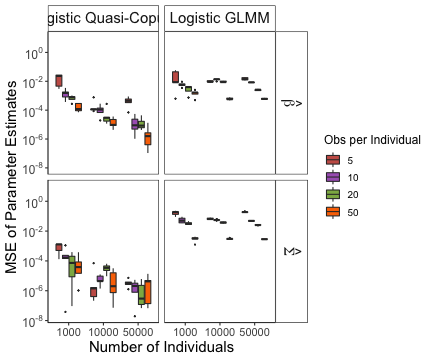

RObject{VecSxp}


In [12]:
### working on figure next
@rput msedfR

R"""
library(scales)
library(ggplot2)
library(data.table)

msedfR = data.table(msedfR)

msedfR[parameters == "beta",y_min := 10^-8]
msedfR[parameters == "beta",y_max := 10^1]
msedfR[parameters == "Sigma",y_min := 10^-5]
msedfR[parameters == "Sigma",y_max := 10^1]

#msedfR[parameters == "beta",y_min := 10^-8]
#msedfR[parameters == "beta",y_max := 10^-2]
#msedfR[parameters == "tau",y_min := 10^-8]
#msedfR[parameters == "tau",y_max := 10^-2]
#msedfR[parameters == "Sigma",y_min := 10^-5]
#msedfR[parameters == "Sigma",y_max := 10^-2]


msedfR$obssize = factor(msedfR$obssize, levels = c('5', '10', '20', '50'))
msedfR$samplesize = factor(msedfR$samplesize, levels = c('1000', '10000','50000'))
msedfR$parameters = factor(msedfR$parameters, levels = c('beta', 'Sigma'), labels = c(beta = expression(hat(bold(beta))), Sigma = expression(hat(bold(Sigma))[])))
msedfR$robust <- factor(msedfR$robust, levels = c('Logistic Quasi-Copula', 'Logistic GLMM'),
    labels = c(expression(paste("Logistic Quasi-Copula")), expression(paste("Logistic GLMM"))))


#mseplot <- ggplot(msedfR[msedfR$mse < 10^0, ], aes(x=samplesize, y=mse, fill=obssize)) + 
mseplot = ggplot(msedfR[msedfR$mse < 10^3, ], aes(x=samplesize, y=mse, fill=obssize)) + 
  #geom_boxplot(outlier.size = 0.0, outlier.alpha = 0) +
  geom_boxplot(outlier.size = 0.25) +
#    geom_violin() +
    facet_grid(parameters ~ robust, labeller = label_parsed, scales = "free_y") +
  theme(legend.position="right", legend.key = element_blank(), axis.text.x = element_text(angle=0, size=11),
        axis.text.y = element_text(angle=0, size=12), axis.title.x = element_text(size = 15), 
        axis.title.y = element_text(size = 15), legend.title = element_text(size = 12),
        panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        legend.text=element_text(size=10), panel.background = element_rect(fill = NA, color = "black"),
        #panel.background = element_blank(), #panel.border = element_blank(),
        axis.line = element_line(color = 'black',size=0.3), plot.title = element_text(hjust = 0.5),
        strip.background = element_rect(colour="black", fill="white"), strip.text.y = element_text(size=15, face="bold"),
        strip.text.x = element_text(size=15)) + 
  scale_fill_manual(values = c("#c85f55",
"#a964bf",
"#8db352",
"#fa7300",
"#05aec0")) +
#scale_y_log10(breaks = scales::trans_breaks("log10", function(x) 10^x)) +
#scale_y_log10(breaks = 10^(-8:8), limit=c(10^-8, 10^2)) + 
scale_y_log10(breaks = 10^seq(-10, 10, 2), labels=trans_format("log10", math_format(10^.x))) + #, limit=c(10^-8, 10^2)) +
  labs(x = "Number of Individuals", y = "MSE of Parameter Estimates", fill = "Obs per Individual") +
geom_blank(aes(y = y_max)) + 
geom_blank(aes(y = y_min)) 

"""

In [13]:
R"""
ggsave('updated_msefacetplot_logistic.png', mseplot, width = 12.5, height = 15, units = 'in', dpi = 450)
"""

RObject{StrSxp}
[1] "updated_msefacetplot_logistic.png"
